In [7]:
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

In [8]:
data = pd.read_csv("./data/IMDB_Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


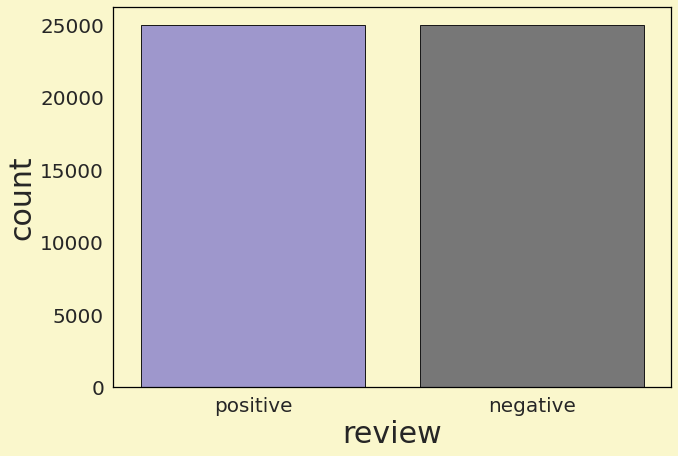

In [79]:
fig, axes = plt.subplots(nrows = 1, ncols =1, figsize = (10, 7),facecolor='#FAF7CC')
sns.set(rc={'axes.facecolor':'#FAF7CC',"axes.edgecolor":"black","axes.grid":False,"axes.labelsize":30,"xtick.labelsize":15,"ytick.labelsize":15})
sns.countplot(x="sentiment",data=data,palette=["#988ed5", "#777777"],edgecolor="k")
plt.xlabel('review');